In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

from sklearn.metrics import mean_squared_error as mse

import itertools as it

import warnings
warnings.filterwarnings('ignore')

## load data

In [2]:
files.upload()

Saving emass.xlsx to emass.xlsx


{'emass.xlsx': b'PK\x03\x04\x14\x00\x06\x00\x08\x00\x00\x00!\x0071\xbd\x91{\x01\x00\x00\x84\x05\x00\x00\x13\x00\x08\x02[Content_Types].xml \xa2\x04\x02(\xa0\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

In [3]:
df = pd.read_excel('emass.xlsx', parse_dates=['Date'])

## data understanding

In [4]:
df.shape, df.isna().sum()

((1258, 7),
 Date      0
 Open      0
 High      0
 Low       0
 Close     0
 Adj       0
 Volume    0
 dtype: int64)

In [5]:
df.info(), df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   Open    1258 non-null   float64       
 2   High    1258 non-null   float64       
 3   Low     1258 non-null   float64       
 4   Close   1258 non-null   float64       
 5   Adj     1258 non-null   float64       
 6   Volume  1258 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 68.9+ KB


(None,
 Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj', 'Volume'], dtype='object'))

In [6]:
df.head()

,Date,Open,High,Low,Close,Adj,Volume
0,2023-11-10,1959.6,1959.6,1932.6,1932.6,1932.6,10
1,2023-11-09,1951.7,1964.2,1945.3,1964.2,1964.2,10
2,2023-11-08,1967.8,1967.8,1947.7,1951.5,1951.5,43
3,2023-11-07,1966.5,1966.8,1960.7,1966.8,1966.8,20
4,2023-11-06,1981.6,1981.6,1977.4,1981.6,1981.6,130


## data preparation

In [7]:
df = df.sort_values('Date')

In [8]:
df['stationer'] = df['Close'].diff()
df.dropna(inplace=True)

In [9]:
data = df[['Date', 'Close']].set_index('Date')

<Axes: xlabel='Date'>

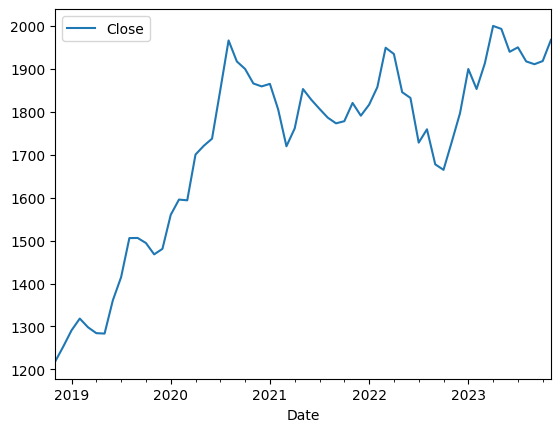

In [10]:
data = data.resample('MS').mean()
data.plot()

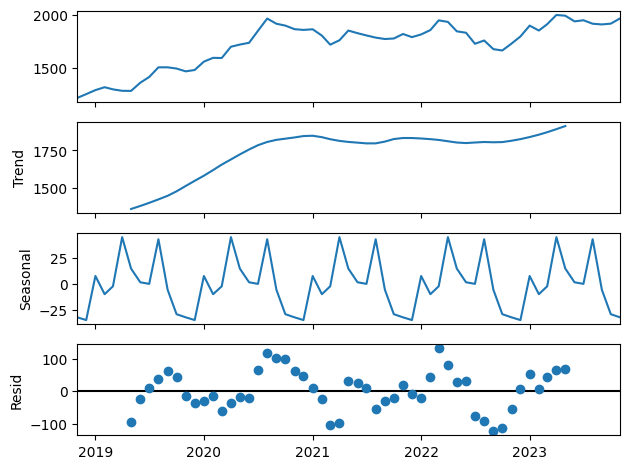

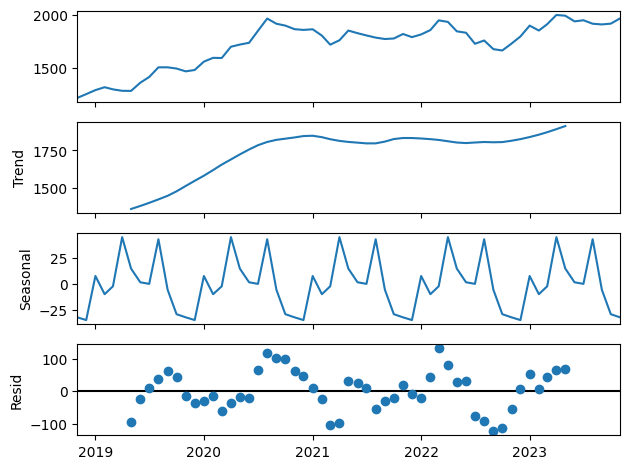

In [11]:
decomposed = seasonal_decompose(data, model='additive')
decomposed.plot()

## split train-test

In [12]:
data.shape

(61, 1)

In [13]:
train = data.iloc[:-12]
test = data.iloc[-12:] #20%

# Modelling

In [14]:
p = q = range(0, 3)
d = range(0,2)
pdq = list(it.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(pdq)]

In [15]:
error=[]
def get_error(data, param1, param2, iter):
    for x in param1:
        for y in param2:
            try:
                mod = SARIMAX(data,
                              order = x,
                              seasonal_order = y)
                hasil = mod.fit(maxiter=iter)
                predik = hasil.get_forecast(steps=12)
                prediction = hasil.predict(len(train), len(train) + len(test)-1)
                error.append([x, y, mse(test, prediction).round(1)])
                # print(f'{x} x {y} : mse = {mse(test, prediction).round(1)}') hapus pagar untuk trace
            except:
                continue

In [16]:
get_error(train, pdq, pdqs, 100)

In [17]:
dataparam = pd.DataFrame(error, columns=['param_order', 'param_seasonal', 'error'])
dataparam = dataparam.sort_values(by = ['error'],ascending=True)[:3]
dataparam

,param_order,param_seasonal,error
322,"(2, 1, 2)","(2, 1, 2, 12)",1069.1
320,"(2, 1, 2)","(2, 1, 0, 12)",1886.8
316,"(2, 1, 2)","(1, 1, 2, 12)",2153.2


In [26]:
hasilprediksi=[]
def get_predict(data, param1, param2, iter):
  mod = SARIMAX(data,  order = param1, seasonal_order = param2)
  hasil = mod.fit(maxiter=iter)
  predik = hasil.get_forecast(steps=12)
  prediction = hasil.predict(len(train), len(train) + len(test) + 5)
  hasilprediksi.append(prediction.round(1))
  plt.plot(test, 'b', label='test')
  plt.plot(prediction, 'r', label='prediction')
  plt.title(f'hasil prediksi dengan parameter {param1} dan {param2}')
  plt.legend()
  return
  plt.show()

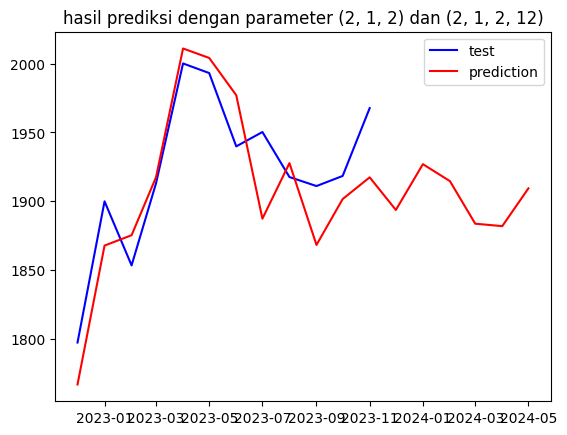

In [27]:
get_predict(train, (2,1,2), (2,1,2,12), 100)

In [28]:
hasilprediksi

[2022-12-01    1766.6
 2023-01-01    1867.7
 2023-02-01    1875.2
 2023-03-01    1917.4
 2023-04-01    2011.1
 2023-05-01    2004.2
 2023-06-01    1977.1
 2023-07-01    1887.2
 2023-08-01    1927.7
 2023-09-01    1868.1
 2023-10-01    1901.5
 2023-11-01    1917.3
 2023-12-01    1893.6
 2024-01-01    1926.9
 2024-02-01    1914.5
 2024-03-01    1883.6
 2024-04-01    1881.8
 2024-05-01    1909.3
 Freq: MS, Name: predicted_mean, dtype: float64]